## Stan tutorial 
* https://www.youtube.com/watch?v=UQtFkEOg9SM&list=PLCrWEzJgSUqwL85xIj1wubGdY15C5Gf7H&index=4

### Linear regression with bayesian
* Linear regression basic form
$$ y = b + \alpha x + \epsilon $$
$$ \epsilon \approx N(0, \sigma) $$

* Distribution of y is uncertain but depends on x, b, $\alpha$, $\sigma$
$$P(y|x, \alpha, b, \sigma) = N(y|b+ \alpha x, \sigma) $$
* We can assume posterior like below

$$P(b, \alpha, \sigma| y, x) = \frac{P(y|x, b, \alpha, \sigma) P(b, \alpha, \sigma, x)}{P(y,x)}$$
$$P(b, \alpha, \sigma| y, x) \approx P(y|x, b, \alpha, \sigma) P(b, \alpha, \sigma, x)$$

In [1]:
import numpy as np
import stan
import nest_asyncio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris
nest_asyncio.apply()
%load_ext autoreload
%autoreload 2


In [2]:
data = load_iris()

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
X = data["data"]

In [5]:
Y = data["target"]

In [6]:
X_df = pd.DataFrame(X)

In [7]:
X_df.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
Y_df = pd.DataFrame(Y)

In [9]:
iris_df = pd.DataFrame(pd.concat([X_df, Y_df], axis=1))

In [10]:
iris_df.columns = list(data.feature_names) + ["target"]

In [11]:
iris_df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [12]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [13]:
target_dic = {0: data.target_names[0], 1: data.target_names[1], 2: data.target_names[2]}

In [14]:
target_dic

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [15]:
iris_df["target"] = iris_df["target"].replace(target_dic)

In [16]:
iris_df_versicolor = iris_df[iris_df["target"] == "versicolor"]

In [17]:
iris_df_versicolor.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor


In [18]:
sepal_length = np.array(iris_df_versicolor["sepal length (cm)"])
petal_length = np.array(iris_df_versicolor["petal length (cm)"])

In [19]:
model = """
data {
    int<lower=0> N; //number of data
    vector[N] x; //covariates
    vector[N] y; //variates
}

parameters {
    real alpha; //slope
    real bias; //intercept
    real<lower=0> sigma; //std
}

model {
    //priors
    bias ~ normal(0, 10);
    alpha ~ normal(0, 10);
    sigma ~ normal(0, 1);

    y ~ normal(bias + alpha * x, sigma);//likelihood
}
"""

In [20]:
data = {"N": len(iris_df_versicolor), "x": sepal_length, "y": petal_length}

In [21]:
posterior = stan.build(model, data=data, random_seed=42)

Building...


Building: found in cache, done.

In [22]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%


Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_w42dcggm/model_jtiuvipq.stan', line 20, column 4 to column 40)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 9.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
  Adjust your expectatio

In [23]:
mean_alpha = np.mean(fit["alpha"][0])
mean_bias = np.mean(fit["bias"][0])

Text(0, 0.5, 'petal length')

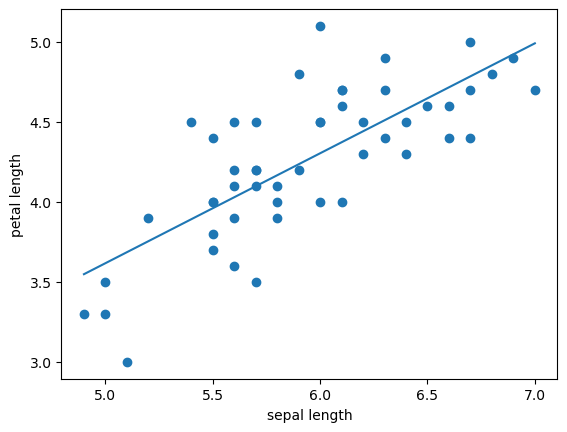

In [24]:
plt.scatter(sepal_length, petal_length)
x = np.linspace(min(sepal_length), max(sepal_length))
y = mean_alpha * x + mean_bias
plt.plot(x, y)
plt.xlabel("sepal length")
plt.ylabel("petal length")

In [25]:
# Assuming params is a dictionary with keys 'alpha' and 'beta', and xr is a numpy array
yCI = np.array(
    [np.percentile(fit["alpha"][0] * k + fit["bias"][0], [5, 95]) for k in x]
)
yCI = yCI.T

Text(0, 0.5, 'petal length')

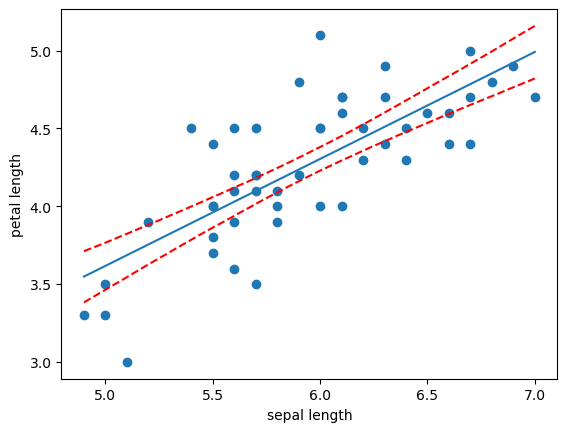

In [26]:
plt.plot(x, yCI[0], color="red", linestyle="--")
plt.plot(x, yCI[1], color="red", linestyle="--")
plt.scatter(sepal_length, petal_length)
plt.plot(x, y)
plt.xlabel("sepal length")
plt.ylabel("petal length")

In [27]:
model_GQ = """
data {
    int<lower=0> N; //number of data
    vector[N] x; //covariates
    vector[N] y; //variates
}

parameters {
    real alpha; //slope
    real bias; //intercept
    real<lower=0> sigma; //std
}

model {
    //priors
    bias ~ normal(0, 10);
    alpha ~ normal(0, 10);
    sigma ~ normal(0, 1);

    y ~ normal(bias + alpha * x, sigma);//likelihood
}

generated quantities {
    vector[N] y_pred;
    for (i in 1:N)
        y_pred[i] = normal_rng(alpha * x[i] + bias, sigma);
}
"""

In [28]:
posterior = stan.build(model_GQ, data=data, random_seed=42)

Building...



Building: 16.8s, done.

In [29]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_ekio3zef/model_amxyrw7v.stan', line 20, column 4 to column 40)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust y

In [30]:
fit.keys()

KeysView(<stan.Fit>
Parameters:
    alpha: ()
    bias: ()
    sigma: ()
    y_pred: (50,)
Draws: 4000)

In [34]:
fit["y_pred"].shape

(50, 4000)

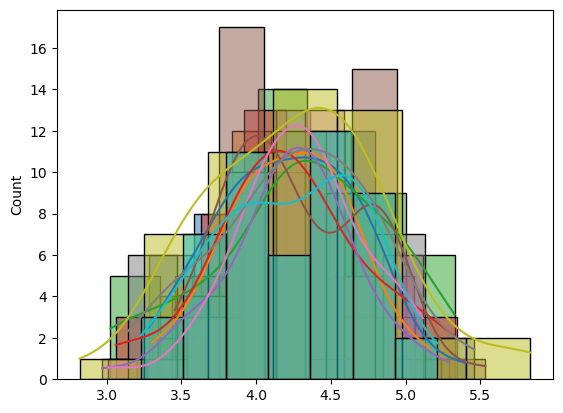

In [38]:
for i in range(10):
    sns.histplot(fit["y_pred"][:, i], kde=True)